# Modelovanie č. 3 - popisné modely

## Načítanie knižníc

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import confusion_matrix, classification_report

## Načítanie dát

In [2]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

## Predspracovanie dát

In [3]:
quantitative = ['src_bytes', 'dst_bytes', 'hot', 'count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']

scaler = StandardScaler()
data[quantitative] = scaler.fit_transform(data[quantitative])

## Modelovanie

### K-means

In [4]:
X_dense = data.drop(columns=['class']).values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

kmeans = KMeans(n_clusters=2, random_state=42)
labels_pca = kmeans.fit_predict(X_pca)

sil_score = silhouette_score(X_pca, labels_pca)

print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.6537047624588013


In [5]:
data['Cluster_PCA'] = labels_pca

cluster_sizes_pca = pd.Series(labels_pca).value_counts()
anomaly_clusters_pca = cluster_sizes_pca[cluster_sizes_pca == cluster_sizes_pca.min()].index

data['Is_Anomaly_PCA'] = np.where(data['Cluster_PCA'].isin(anomaly_clusters_pca), 1, 0)

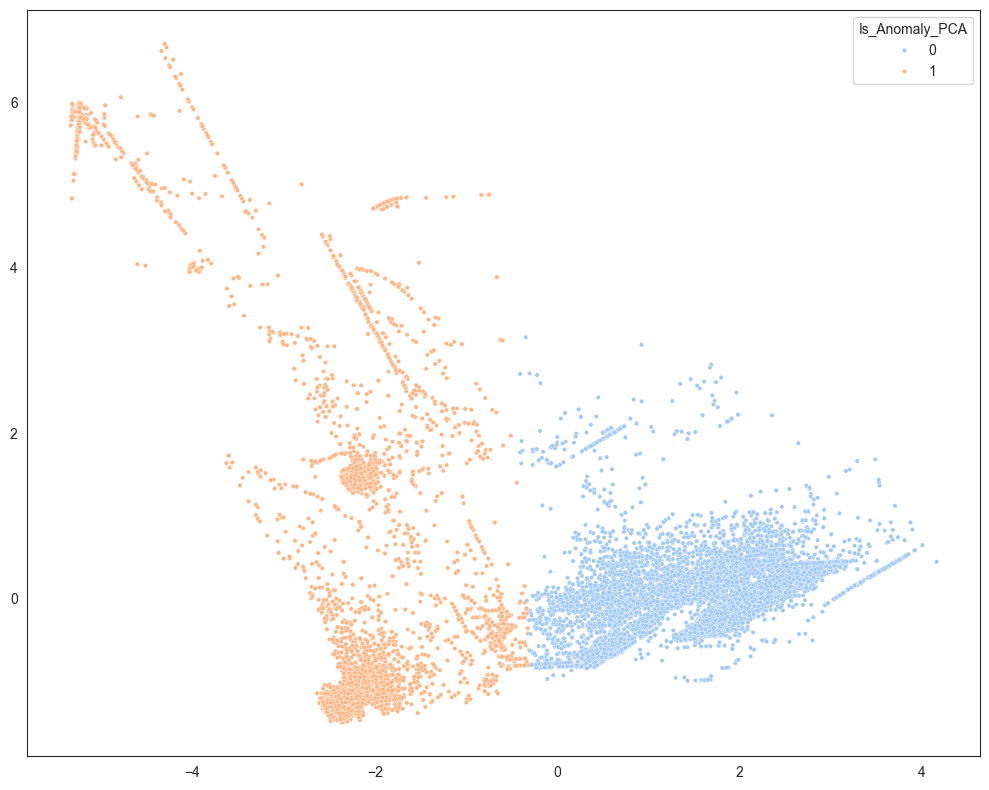

In [6]:
sns.set_style('white')
plt.figure(figsize=(10, 8))
scatter_pca = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Is_Anomaly_PCA'], palette='pastel', s=10)
plt.tight_layout()
plt.savefig('pca.png', dpi=300)
plt.show()

{'Normal': {'precision': 0.8705010334259853, 'recall': 0.9937352534374746, 'f1-score': 0.9280449813843933, 'support': 12291.0}, 'Anomaly': {'precision': 0.9923023093072079, 'recall': 0.8452695222685855, 'f1-score': 0.9129035224868941, 'support': 11743.0}, 'accuracy': 0.9211949737871349, 'macro avg': {'precision': 0.9314016713665966, 'recall': 0.9195023878530301, 'f1-score': 0.9204742519356437, 'support': 24034.0}, 'weighted avg': {'precision': 0.9300130739799171, 'recall': 0.9211949737871349, 'f1-score': 0.9206468723790953, 'support': 24034.0}}


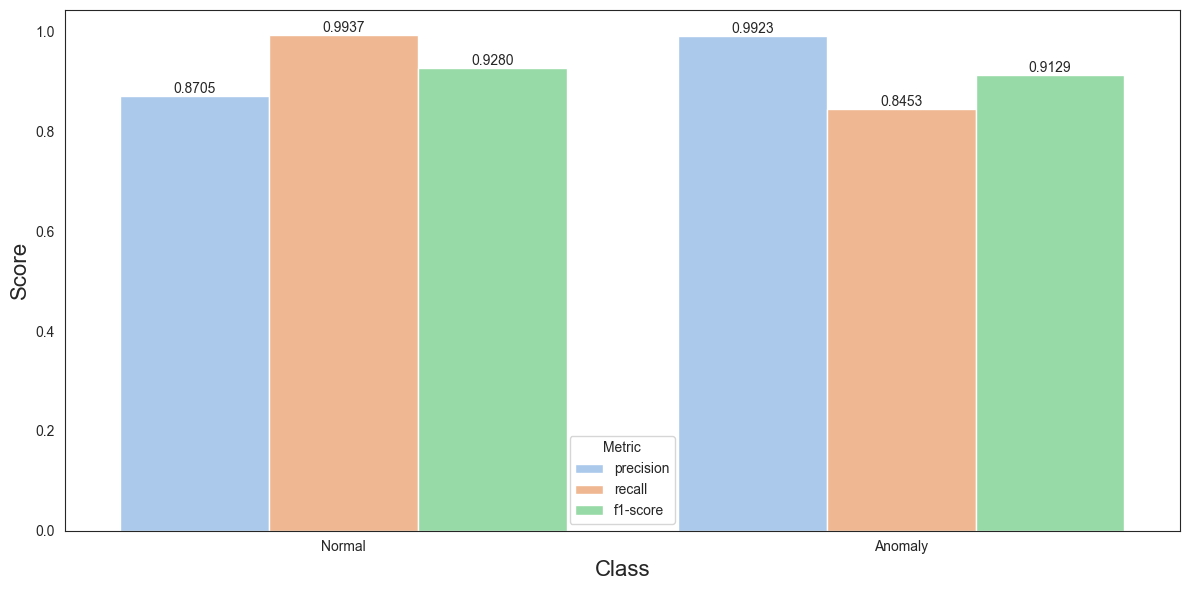

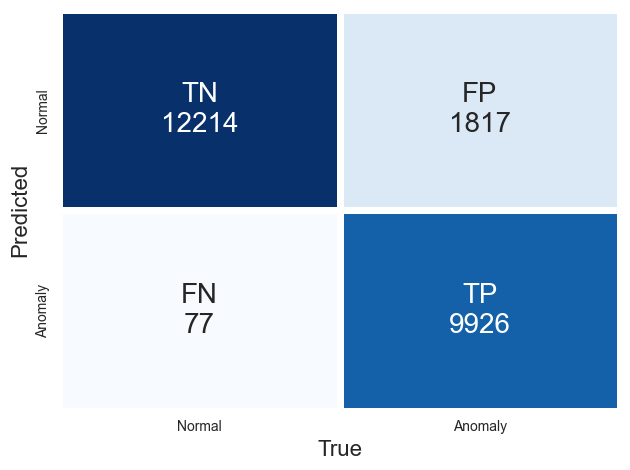

In [7]:
true_labels = data['class']
predicted_labels = data['Is_Anomaly_PCA']
target_names = ['Normal', 'Anomaly']

cm = confusion_matrix(true_labels, predicted_labels).T
tn, fp, fn, tp = cm.ravel()
annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

report = classification_report(true_labels, predicted_labels, target_names=target_names, output_dict=True)
print(report)
report_df = pd.DataFrame(report).transpose().reset_index()

report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.xlabel('Class', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.legend(title='Metric')
plt.tight_layout()
#plt.savefig(f'pca_metrics.png', dpi=300)
plt.show()


sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names,
            cbar=False, annot_kws={'size': 20})
plt.xlabel('True', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tight_layout()
#plt.savefig(f'pca_cm.png', dpi=300)
plt.show()

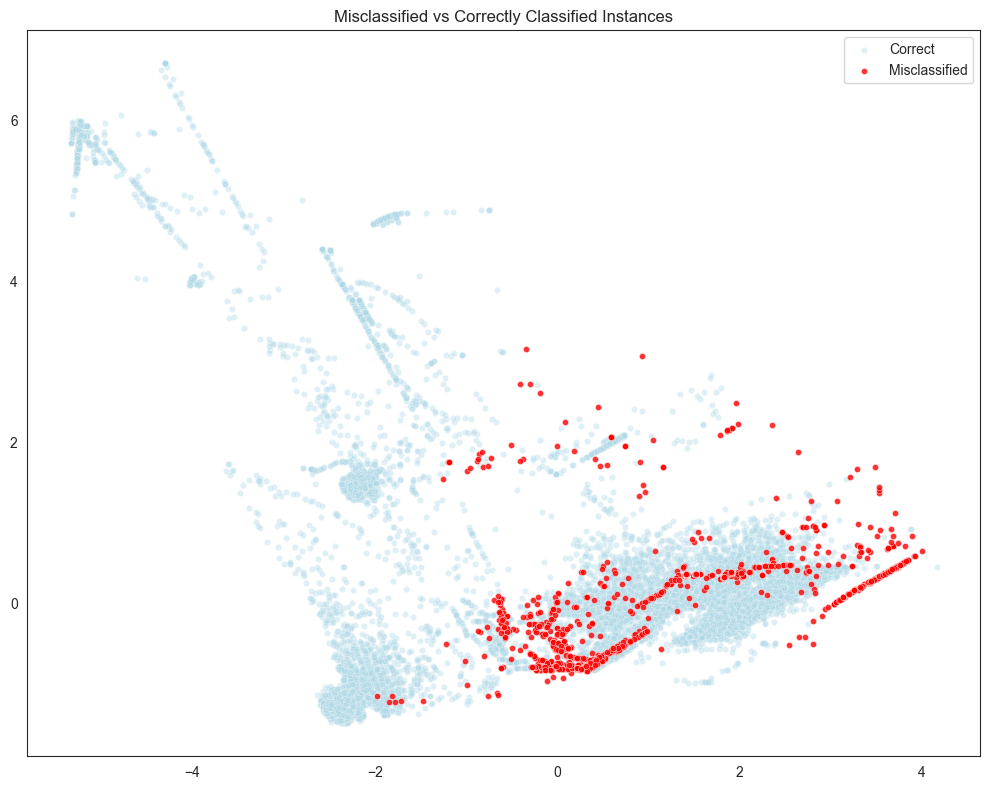

In [8]:
misclassified = true_labels != predicted_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[~misclassified, 0], y=X_pca[~misclassified, 1], label='Correct', color='lightblue', s=20, alpha=0.4)
sns.scatterplot(x=X_pca[misclassified, 0], y=X_pca[misclassified, 1], label='Misclassified', color='red', s=20, alpha=0.8)
plt.legend()
plt.title('Misclassified vs Correctly Classified Instances')
plt.tight_layout()
#plt.savefig('miss_true.png', dpi=300)
plt.show()

### Asociačné pravidlá

In [11]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

quantitative = ['src_bytes', 'dst_bytes', 'hot', 'count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']

binary_data = data.copy()

for col in quantitative:
    binary_data[col] = (binary_data[col] > binary_data[col].median()).astype(bool)

frequent_itemsets = apriori(binary_data, min_support=0.01, use_colnames=True)

print(frequent_itemsets.sort_values(by='support', ascending=False))
frequent_itemsets.sort_values(by='support', ascending=False).to_csv('frequent_itemsets.csv', index=False)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7, num_itemsets=2)
#rules.to_csv('association_rules.csv', index=False)

/Users/m4/miniconda3/envs/oz/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                                           itemsets
3    0.499293                                            (count)
7    0.498877                           (dst_host_same_srv_rate)
0     0.49093                                        (src_bytes)
9    0.488599                                            (class)
8      0.4881                           (dst_host_diff_srv_rate)
..        ...                                                ...
164  0.010319  (dst_bytes, serror_rate, src_bytes, service_http)
35   0.010152                                (service_http, hot)
167  0.010152  (service_http, src_bytes, dst_host_same_srv_ra...
86   0.010152                     (service_http, src_bytes, hot)
109  0.010152        (service_http, dst_host_same_srv_rate, hot)

[235 rows x 2 columns]
                                           antecedents  \
0                                          (dst_bytes)   
1                                          (src_bytes)   
2                     

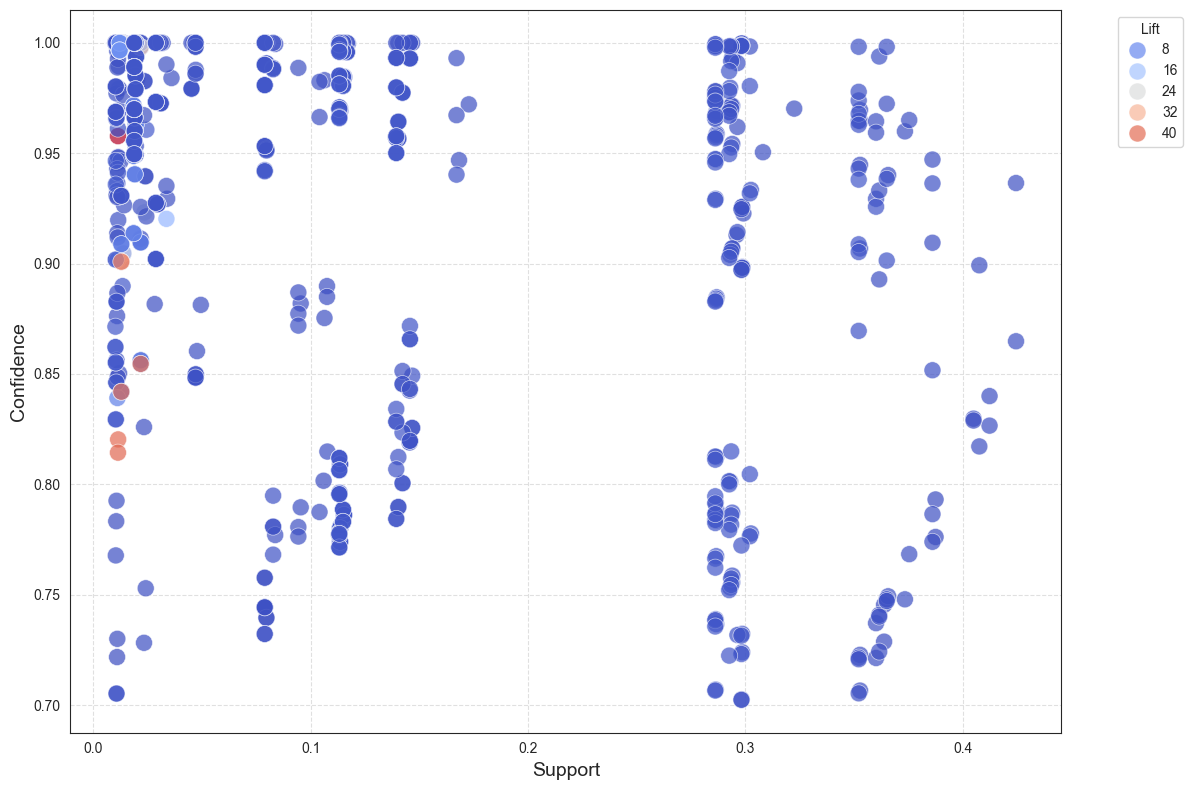

In [28]:
sns.set_style('white')

rules_df = pd.read_csv('data/association_rules.csv')

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=rules_df, x='support', y='confidence', hue='lift', palette='coolwarm', s=150, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.xlabel('Support', fontsize=14)
plt.ylabel('Confidence', fontsize=14)
plt.legend(title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('association_rules_scatterplot.png', dpi=300)
plt.show()